In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from datetime import date
from datetime import timedelta
import eikon as ek
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

In [197]:
Date_1y = datetime.today() - timedelta(365)
data = ek.get_timeseries("BTC=", "CLOSE", Date_1y.strftime("%Y-%m-%d"), date.today().strftime("%Y-%m-%d"))

In [198]:
data.head()

BTC=,CLOSE
Date,
2021-08-12,44485.5
2021-08-13,47614.16
2021-08-14,46662.92
2021-08-15,46714.03
2021-08-16,46080.77


In [199]:
data['returns'] = np.log(data / data.shift(1))

In [200]:
data.dropna(inplace=True)

In [201]:
# If return is positive, then direction is 1; otherwise, -1
data['direction'] = np.sign(data['returns']).astype(int)

In [202]:
data.head()

BTC=,CLOSE,returns,direction
Date,,,
2021-08-13,47614.16,0.067967,1
2021-08-14,46662.92,-0.02018,-1
2021-08-15,46714.03,0.001095,1
2021-08-16,46080.77,-0.013649,-1
2021-08-17,44975.26,-0.024283,-1


<AxesSubplot:>

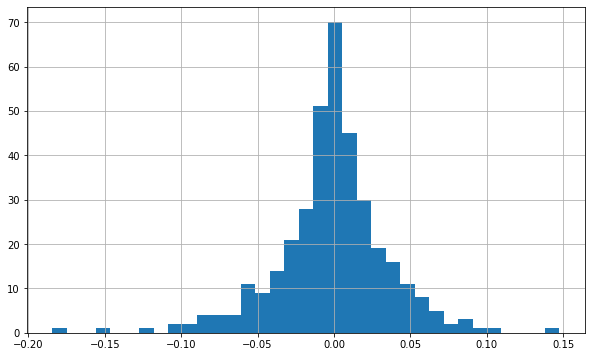

In [203]:
data['returns'].hist(bins=35, figsize=(10, 6))

In [204]:
data['lag_1'] = data['returns'].shift(1)
data['lag_2'] = data['returns'].shift(2)

In [205]:
data.dropna(inplace=True)

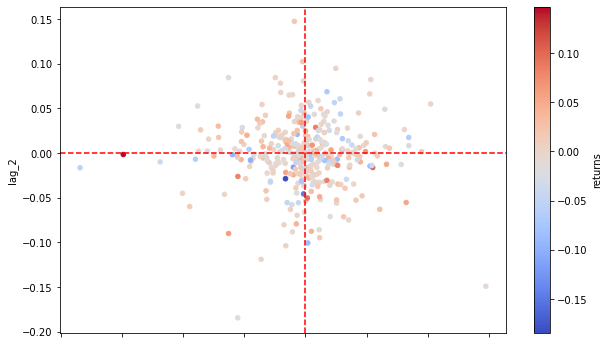

In [206]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')

In [207]:
data['returns'] = pd.to_numeric(data['returns'])

In [208]:
# The regression is implemented on the log returns directly 
reg6 = smf.ols(formula="returns ~ lag_1 + lag_2", data= data).fit()
data['pos_ols_1'] = reg6.predict()

In [209]:
# The regression is implemented on the direction data which is of primary interest.
reg7 = smf.ols(formula="direction ~ lag_1 + lag_2", data=data).fit()
data['pos_ols_2'] = reg7.predict()

In [210]:
data[['pos_ols_1', 'pos_ols_2']].head()

BTC=,pos_ols_1,pos_ols_2
Date,,
2021-08-15,0.001095,1.0
2021-08-16,-0.013649,-1.0
2021-08-17,-0.024283,-1.0
2021-08-18,-0.009807,-1.0
2021-08-19,0.044946,1.0


In [211]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [212]:
data['pos_ols_1'].value_counts()

-1    182
 1    181
Name: pos_ols_1, dtype: int64

In [213]:
data['pos_ols_2'].value_counts()

-1    182
 1    181
Name: pos_ols_2, dtype: int64

In [214]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [215]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [216]:
# actual returns agaist potential returns on using strategy 1 or 2 (which are equal in this instance!)
np.exp(data[['returns', 'strat_ols_1', 'strat_ols_2']].sum())

BTC=
returns           0.519792
strat_ols_1    8554.913954
strat_ols_2    8554.913954
dtype: float64

In [217]:
# Shows the number of correct and false predictions by the strategies.
(data['direction'] == data['pos_ols_1']).value_counts()

True     360
False      3
dtype: int64

In [218]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     360
False      3
dtype: int64

<AxesSubplot:xlabel='Date'>

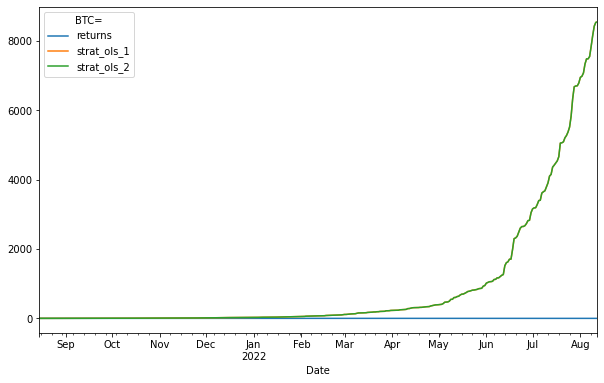

In [219]:
np.exp(data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum()).plot(figsize=(10, 6))